# Descriptives Statistics

Basic statistics about monthly trends

Last updated: 19.06.2018.

Created by: Orsi Vasarhelyi

In [1]:
import json
import os
import pickle
import psycopg2
import pandas as pd
import sqlalchemy

import sys
sys.path.append("..")
from connect_db import db_connection

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
username='ovasarhelyi'

In [4]:
cred_location = '/mnt/data/'+username+'/TPT_tourism/connect_db/data_creds_redshift.json.nogit'
db = db_connection.DBConnection(cred_location)

# Read MCC data

In [5]:
# read the country codes in
mcc=pd.read_csv('/mnt/data/shared/mcc-mnc-table.csv')
mcc_country=mcc.drop_duplicates("MCC", keep='first')[['MCC', 'Country']]
mcc_country['mcc']=mcc_country['MCC'].astype(int)

def clean_guam(row):
    if row['Country']=='Guam':
        return 'United States'
    else:
        return row['Country']
mcc_country['Country']=mcc_country.apply(clean_guam,1)

# Histogram about number of locations visited in Italy (by months) by country

In [6]:
#Histogram about number of locations visited in Italy (by months)

query1="""select 
	extract(month from time_stamp) as given_month,
	mcc,
	count(distinct location_id) as num_loc_in_italy
from tpt.tuscany.vodafone
group by extract(month from time_stamp), mcc
order by given_month, mcc desc"""

In [7]:
num_loc_month= db.sql_query_to_data_frame(query1)

In [23]:
num_loc_month.head()

,given_month,mcc,num_loc_in_italy
0,1,996.0,2
1,1,993.0,1
2,1,991.0,1
3,1,987.0,1
4,1,982.0,1


In [53]:
s1 = pd.DataFrame.from_dict({'num_ppl_in_italy':[0,0],
                            'index':[3,4]})

In [58]:
s2 = pd.DataFrame.from_dict({'num_loc_in_italy':[0,0],
                            'index':[3,4]})

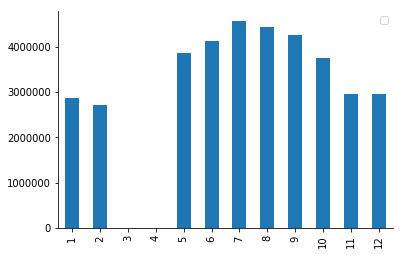

In [65]:
b=pd.DataFrame(num_loc_month.groupby("given_month")['num_loc_in_italy'].sum())
ax1=b.append(s2.set_index('index')).sort_index().plot(kind='bar')
ax1.set_ylim(ymin=0)
sns.despine()
plt.legend("")

In [9]:
country_loc=pd.DataFrame(num_loc_month.groupby("mcc")['num_loc_in_italy'].sum().sort_values(ascending=False))

In [10]:
locs_country=country_loc.join(mcc_country.set_index('mcc'))

# Number of people by country, month in whole Italy

In [11]:

query2="""select 
	extract(month from time_stamp) as given_month,
	mcc,
	count(distinct customer_id) as num_ppl_in_italy
from tpt.tuscany.vodafone
group by extract(month from time_stamp), mcc
order by given_month, mcc desc"""

In [12]:
num_ppl_month= db.sql_query_to_data_frame(query2)

In [13]:
num_ppl_month.head()

,given_month,mcc,num_ppl_in_italy
0,1,996.0,1
1,1,993.0,1
2,1,991.0,1
3,1,987.0,1
4,1,982.0,1


In [51]:
a2=pd.DataFrame(num_ppl_month.groupby("given_month")['num_ppl_in_italy'].sum())

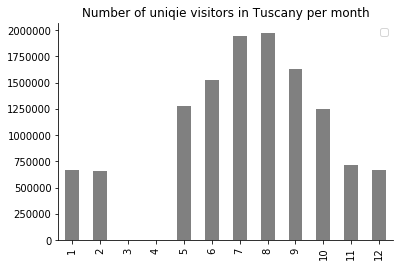

In [70]:
a3=a2.append(s1.set_index('index')).sort_index().plot(kind='bar', color='grey', title='Number of uniqie visitors in Tuscany per month')
ax2.set_ylim(ymin=0)
sns.despine()
plt.legend("")

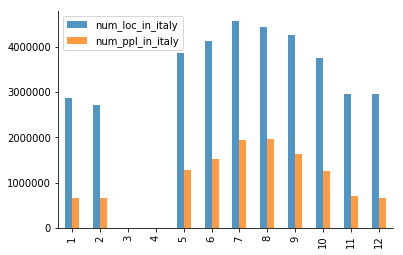

In [80]:
b.append(s2.set_index('index')).sort_index().join(a2.append(s1.set_index('index')).sort_index()).plot(kind='bar', alpha=0.78)
sns.despine()

# Num locations vs num people

In [17]:
b=pd.DataFrame(num_ppl_month.groupby("mcc")['num_ppl_in_italy'].sum())

In [18]:
mcc_country.index=mcc_country.mcc.index.astype(float)

In [19]:
ppl_loc=country_loc.join(b).join(mcc_country.set_index('mcc'))

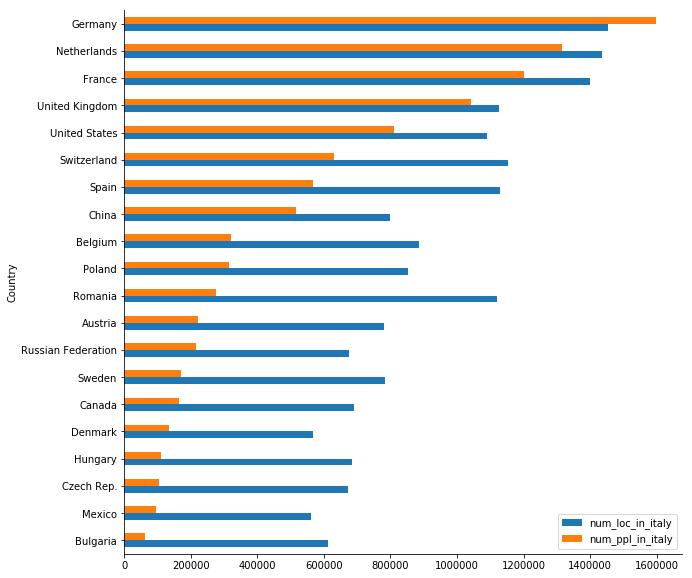

In [20]:
ppl_loc.set_index('Country')[['num_loc_in_italy', 'num_ppl_in_italy']][:20].sort_values('num_ppl_in_italy', ascending=True).plot(kind='barh', figsize=(10,10))
sns.despine()

### notes and recommendations: 

- we need to figure out their entry points and the reason of the movements
- who is a tourist, how are we exclude those who just cross the country and not even spend a full day in Tuscany
- we can cut the data to different seasons, ot at least take summer out
